## Problem 2 (a)

In [1]:
#import packagse that be used
import numpy as np
import csv
from scipy.stats import norm
from numpy.linalg import inv
import math
from matplotlib import pyplot as plt
from collections import defaultdict
import pandas as pd
import warnings; warnings.simplefilter('ignore')

%matplotlib inline 

In [2]:
#read the data and return list of user_id, movie_id, and their ratings seperately
def readData(data):
    user_id = []
    movie_id = []
    ratings = []

    with open(data) as csvfile:
        ratingsCsv = csv.reader(csvfile, delimiter = ',')
        for line in ratingsCsv:
            line0 = int(line[0])
            line1 = int(line[1])
            line2 = int(line[2])
            user_id.append(line0)
            movie_id.append(line1)
            ratings.append(line2)

    return user_id,movie_id,ratings


In [3]:
#put ratings into a matrix correspond to their user and moive, user on the row and movie on the column
def ratMaxtrix(user_idnp,movie_idnp,ratingsnp):
    ratMat = np.zeros((np.amax(user_idnp),np.amax(movie_idnp)))
    for i in range(np.shape(ratingsnp)[0]):
        ratMat[user_idnp[i] - 1,movie_idnp[i] - 1] = ratingsnp[i]
    return ratMat

In [4]:
#store user info as a dictionary, each user will correspond to a list of moives they watch
def dict_user_movie(user_id,movie_id):
    user = defaultdict(list)
    for k, v in zip(user_id, movie_id):
        user[k].append(v)
    return user

In [5]:
#store moive info as a dictionary, each moive will correspond to a list of users that watched this moive
def dict_movie_user(user_id,movie_id):
    movie = defaultdict(list)
    for k, v in zip(user_id, movie_id):
        if v == 1325:
            print(v)
        movie[v].append(k)
        
    return movie

In [6]:
#calculate expecated value of q(E step in the EM)
def calEqfi_t(U_pt,V_pt,ratMat,sigma,user_idnp, movie_idnp):
    Eqfi_t = np.zeros ((np.shape(ratMat)))
    a = np.dot(U_pt.T,V_pt)
    numerator = norm.pdf(-a / 1,0,1)
    numerator2 = -norm.pdf(-a / 1,0,1)
    denominator = 1 - norm.cdf(-a / 1,0,1)
    denominator2 = norm.cdf(-a / 1,0,1)
    Eqfi_t1 = a + sigma * numerator / denominator
    Eqfi_t2 = a + sigma * numerator2 / denominator2
    for i in range(np.shape(ratingsnp)[0]):
        if int(ratMat[user_idnp[i] - 1,movie_idnp[i] - 1]) == 1:
            Eqfi_t[user_idnp[i] - 1,movie_idnp[i] - 1] = Eqfi_t1[user_idnp[i] - 1,movie_idnp[i] - 1]
        if int(ratMat[user_idnp[i] - 1,movie_idnp[i] - 1]) == -1:
            Eqfi_t[user_idnp[i] - 1,movie_idnp[i] - 1] = Eqfi_t2[user_idnp[i] - 1,movie_idnp[i] - 1]
    
    return Eqfi_t


In [7]:
#update U useing U,V q matrix from previous iteration(M Step_U)
def updateU(Eqfi_t,U_pt,V_pt,ratMat,c,d,sigma,user_idnp,movie_idnp,user):
    U_t = np.zeros(np.shape(U_pt))
    for i in range(np.shape(ratMat)[0]):    
        V_vec = np.zeros((d,1))
        if user[i + 1] != []:
            useri = np.array(user[i + 1]) - 1
            VVT = np.dot(V_pt[:,useri],V_pt[:,useri].T) 
            VVT = VVT / sigma ** 2 + 1 * c * np.identity(d)
            inverse = inv(VVT)
            for j in user[i + 1]:
                V_vec = V_vec + V_pt[::1,j - 1:j:1] * Eqfi_t[i,j-1]
            U_t[:,i] = np.dot(inverse,V_vec.reshape(d,1)).flatten()
    return U_t
                
#update V useing U,V q matrix from previous iteration(M Step_V)            
def updateV(Eqfi_t,U_pt,V_pt,ratMat,c,d,sigma,user_idnp,movie_idnp,movie):
    V_t = np.zeros(np.shape(V_pt))
    for i in range(np.shape(ratMat)[1]):
        U_vec = np.zeros((d,1))
        if movie[i + 1] != []:
            moviei = np.array(movie[i + 1]) - 1
            UUT = np.dot(U_pt[:,moviei],U_pt[:,moviei].T)
            UUT = UUT / sigma ** 2 + 1 * c * np.identity(d)
            inverse = inv(UUT)
            for j in movie[i + 1]:
                U_vec = U_vec + U_pt[::1,j - 1:j:1] * Eqfi_t[j - 1,i]
            V_t[:,i] = np.dot(inverse,U_vec.reshape(d,1)).flatten()
    return V_t

In [8]:
#calculate the jointly likelihood of the R,U,V
def calLnlikeli(U,V,simga,user_idnp,movie_idnp,ratMat,ratingsnp,c):
    b = np.dot(U.T,V)
    a1 = np.log(norm.cdf(b,0,1))
    a2 = np.log(1 - norm.cdf(b,0,1))
    n,m = np.shape(ratMat)
    d = np.shape(U)[0]
    lnlikeli = 0
    UTU = np.zeros(n)
    VTV = np.zeros(m)
    for i in range(np.shape(user_idnp)[0]):
        if ratingsnp[i] == 1:
            lnlikeli = lnlikeli + a1[user_idnp[i] - 1, movie_idnp[i] - 1]
        if ratingsnp[i] == -1:
            lnlikeli = lnlikeli + a2[user_idnp[i] - 1, movie_idnp[i] - 1]
    for i1 in range(n):
        UTU[i1] = np.dot(U[:,i1].T,U[:,i1])
    for j1 in range(m):
        VTV[j1] = np.dot(V[:,j1].T,V[:,j1])
         
    lnlikeli - 1/(2 * c) * (np.sum(UTU) + np.sum(VTV)) - (n+m) * d * math.log(2 * math.pi * c) / 2
    return lnlikeli
    

In [9]:
#train the EM algorithm and return U,V and joint log likelihood
def train(iteration,U,V,ratMat,c,d,sigma,user_idnp,movie_idnp,user,movie):
    loglike = np.zeros(100)
    U_pt = np.array(U,copy = True)
    V_pt = np.array(V,copy = True)
    for i in range(iteration):
        Eqfi_t = calEqfi_t(U_pt,V_pt,ratMat,sigma,user_idnp, movie_idnp)
        U = updateU(Eqfi_t,U_pt,V_pt,ratMat,c,d,sigma,user_idnp,movie_idnp,user)
        V = updateV(Eqfi_t,U_pt,V_pt,ratMat,c,d,sigma,user_idnp,movie_idnp,movie)
        U_pt = np.array(U,copy = True)
        V_pt = np.array(V,copy = True)
        loglike[i] = calLnlikeli(U_pt,V_pt,sigma,user_idnp,movie_idnp,ratMat,ratingsnp,c)
    return U,V,loglike

In [10]:
#compute the accuracy for the EM algorithm and components of confusion matrix, p denote positive, n denote negative
def calConMat(U,V,user_id,movie_id,ratings):
    p_p = 0
    p_n = 0
    n_p = 0
    n_n = 0
    pre = np.dot(U.T,V)
    accuracy = 0  
    for i in range(np.shape(user_id)[0]):
        if pre[user_id[i] - 1][movie_id[i] - 1] > 0 and ratings[i] == 1:
            p_p  = p_p + 1
        elif pre[user_id[i] - 1][movie_id[i] - 1] <= 0 and ratings[i] == -1:
            n_n = n_n + 1
        elif pre[user_id[i] - 1][movie_id[i] - 1] > 0 and ratings[i] == -1:
            p_n = p_n + 1
        elif pre[user_id[i] - 1][movie_id[i] - 1] <= 0 and ratings[i] == 1:
            n_p = n_p + 1
    accuracy = (p_p + n_n) / (p_p + n_p + n_n + p_n)
    return p_p,p_n,n_p,n_n,accuracy

In [11]:
#create confusion matrix
def confusionMat(n_n,p_n,n_p,p_p):
    table = pd.DataFrame([[n_n,n_p],[p_n,p_p]])
    table.index.name = ["predict dislike","predict like"]
    table.columns = ["actually dislike","actually like"]
    return table

In [12]:
#load data
data = 'ratings.csv'
user_id, movie_id, ratings = readData(data)

In [19]:
ratingss = pd.read_csv('ratings.csv')

In [20]:
ratingss

,196,242,-1
0,186,302,-1
1,244,51,-1
2,166,346,-1
3,298,474,1
4,115,265,-1
5,253,465,1
6,305,451,-1
7,6,86,-1
8,62,257,-1
9,286,1014,1


In [13]:
#put everything into numpy
user_idnp = np.array(user_id)
movie_idnp = np.array(movie_id)
ratingsnp = np.array(ratings)
ratMat = ratMaxtrix(user_idnp,movie_idnp,ratingsnp)

In [14]:
#initialize U and V and parameters
d = 5
c = 1
sigma = 1

mean = np.zeros(d)
coVar = np.identity(d) * 0.1
U = np.random.multivariate_normal(mean,coVar,np.amax(user_idnp)).T
V = np.random.multivariate_normal(mean,coVar,np.amax(movie_idnp)).T

user = dict_user_movie(user_id,movie_id)
movie = dict_movie_user(user_id,movie_id)

In [15]:
#train U and V
iteration = 100
Uinit,Vinit,loglikeinit = train(iteration,U,V,ratMat,c,d,sigma,user_idnp,movie_idnp,user,movie)

Text(0.5,1,'log likelihood')

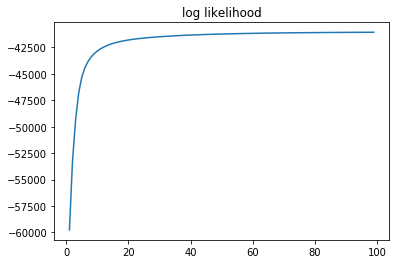

In [27]:
#question 1 plot
plt.plot(np.arange(1,100),loglikeinit[1:])
plt.title("log likelihood")

## Question 2(b)

In [17]:
#read in the rartins test data set
dataTest = 'ratings_Test.csv'
user_idTest,movie_idTest,ratingsTest = readData(dataTest)

In [18]:
#initialize using mean of 0 and identity covariance matrix 0.2
mean1 = np.zeros(d)
coVar1 = np.identity(d) * 0.2
U1 = np.random.multivariate_normal(mean1,coVar1,np.amax(user_idnp)).T
V1 = np.random.multivariate_normal(mean1,coVar1,np.amax(movie_idnp)).T
U1,V1,loglike1 = train(iteration,U1,V1,ratMat,c,d,sigma,user_idnp,movie_idnp,user,movie)

#initialize using mean of 0 and identity covariance matrix 0.3
mean2 = np.zeros(d)
coVar2 = np.identity(d) * 0.3
U2 = np.random.multivariate_normal(mean2,coVar2,np.amax(user_idnp)).T
V2 = np.random.multivariate_normal(mean2,coVar2,np.amax(movie_idnp)).T
U2,V2,loglike2 = train(iteration,U2,V2,ratMat,c,d,sigma,user_idnp,movie_idnp,user,movie)

#initialize using mean of 0 and identity covariance matrix 0.4
mean3 = np.zeros(d)
coVar3 = np.identity(d) * 0.4
U3 = np.random.multivariate_normal(mean3,coVar3,np.amax(user_idnp)).T
V3 = np.random.multivariate_normal(mean3,coVar3,np.amax(movie_idnp)).T
U3,V3,loglike3 = train(iteration,U3,V3,ratMat,c,d,sigma,user_idnp,movie_idnp,user,movie)

#initialize using mean of 1 and identity covariance matrix 0.5
mean4 = np.zeros(d) + 1
coVar4 = np.identity(d) * 0.5
U4 = np.random.multivariate_normal(mean4,coVar4,np.amax(user_idnp)).T
V4 = np.random.multivariate_normal(mean4,coVar4,np.amax(movie_idnp)).T
U4,V4,loglike4 = train(iteration,U4,V4,ratMat,c,d,sigma,user_idnp,movie_idnp,user,movie)

#initialize using mean of 0.2 and identity covariance matrix 0.3
mean5 = np.zeros(d) + 0.2
coVar5 = np.identity(d) * 0.3
U5 = np.random.multivariate_normal(mean5,coVar5,np.amax(user_idnp)).T
V5 = np.random.multivariate_normal(mean5,coVar5,np.amax(movie_idnp)).T
U5,V5,loglike5 = train(iteration,U5,V5,ratMat,c,d,sigma,user_idnp,movie_idnp,user,movie)


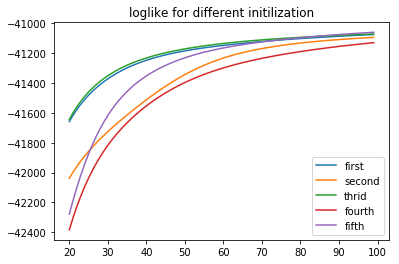

In [19]:
x = np.arange(20,100)
plt.plot(x,loglike1[20:],label = "first")
plt.plot(x,loglike2[20:],label = "second")
plt.plot(x,loglike3[20:],label = "thrid")
plt.plot(x,loglike4[20:],label = "fourth")
plt.plot(x,loglike5[20:],label = "fifth")
plt.title("loglike for different initilization")
plt.legend()

## Question2 (C)

In [20]:
p_p,p_n,n_p,n_n,accuracy = calConMat(Uinit,Vinit ,user_idTest,movie_idTest,ratingsTest)
p_p1,p_n1,n_p1,n_n1,accuracy1 = calConMat(U1,V1,user_idTest,movie_idTest,ratingsTest)
p_p2,p_n2,n_p2,n_n2,accuracy2 = calConMat(U2,V2,user_idTest,movie_idTest,ratingsTest)
p_p3,p_n3,n_p3,n_n3,accuracy3 = calConMat(U3,V3,user_idTest,movie_idTest,ratingsTest)
p_p4,p_n4,n_p4,n_n4,accuracy4 = calConMat(U4,V4,user_idTest,movie_idTest,ratingsTest)
p_p5,p_n5,n_p5,n_n5,accuracy5 = calConMat(U5,V5,user_idTest,movie_idTest,ratingsTest)

In [21]:
#confusion matrix for the itinal set up
print(confusionMat(n_n,p_n,n_p,p_p))
print("accuracy",accuracy)

                                 actually dislike  actually like
[predict dislike, predict like]                                 
0                                            1433            612
1                                             833           2122
accuracy 0.711


In [22]:
#confusion matrix for the first different set up
print(confusionMat(n_n1,p_n1,n_p1,p_p1))
print("accuracy1",accuracy1)

                                 actually dislike  actually like
[predict dislike, predict like]                                 
0                                            1426            603
1                                             840           2131
accuracy1 0.7114


In [23]:
#confusion matrix for second different set up
print(confusionMat(n_n2,p_n2,n_p2,p_p2))
print("accuracy2",accuracy2)

                                 actually dislike  actually like
[predict dislike, predict like]                                 
0                                            1436            597
1                                             830           2137
accuracy2 0.7146


In [24]:
#confusion matrix for third different set up
print(confusionMat(n_n3,p_n3,n_p3,p_p3))
print("accuracy3",accuracy3)

                                 actually dislike  actually like
[predict dislike, predict like]                                 
0                                            1442            615
1                                             824           2119
accuracy3 0.7122


In [25]:
#confusion matrix for fourth different set up
print(confusionMat(n_n4,p_n4,n_p4,p_p4))
print("accuracy4",accuracy4)

                                 actually dislike  actually like
[predict dislike, predict like]                                 
0                                            1414            634
1                                             852           2100
accuracy4 0.7028


In [26]:
#confusion matrix for fifth different set up
print(confusionMat(n_n5,p_n5,n_p5,p_p5))
print("accuracy5",accuracy5)

                                 actually dislike  actually like
[predict dislike, predict like]                                 
0                                            1426            617
1                                             840           2117
accuracy5 0.7086
